In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        continue
#         print(os.path.join(dirname, filename))
    

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [23]:
# load in label csv and organize of alphabetical order by pokemon name and shuffle data
data_labels = pd.read_csv('/kaggle/input/pokemon-images-and-types/pokemon.csv')
# data_labels_name_sorted = data_labels.sort_values(by='Name', ascending=True).reset_index(drop=True)
data_labels_name_sorted = data_labels.sample(frac=1).reset_index(drop=True)
data_labels_name_sorted

,Name,Type1,Type2
0,riolu,Fighting,NaN
1,pancham,Fighting,NaN
2,omanyte,Rock,Water
3,keldeo-ordinary,Water,Fighting
4,whiscash,Water,Ground
...,...,...,...
804,sceptile,Grass,NaN
805,altaria,Dragon,Flying
806,dewott,Water,NaN
807,tyrogue,Fighting,NaN


In [24]:
# os.listdir('/kaggle/input/pokemon-images-and-types/images/images')
directory = '/kaggle/input/pokemon-images-and-types/images/images'
total_bytes = sum(os.path.getsize(os.path.join(directory, filename)) for filename in os.listdir(directory))

# Convert the total size to gigabytes
total_gb = total_bytes / (1024 ** 3)

print(f'The total size of the directory is {total_gb:.2f} GB')
print(total_bytes)

The total size of the directory is 0.00 GB
2508596


In [25]:
png_directory = '/kaggle/input/pokemon-images-and-types/images/images'
for filename in os.listdir(png_directory):
    if filename.endswith('.png') or filename.endswith('.jpg'):
        # Load the PNG image using PIL
        img = Image.open(os.path.join(png_directory, filename))

In [26]:
pokemon_to_arrays = {}
pokemon_to_arrays_without_convert = {}
png_directory = '/kaggle/input/pokemon-images-and-types/images/images'
# Loop through each file in the directory
for filename in os.listdir(png_directory):
    if filename.endswith('.png') or filename.endswith('.jpg'):
        # Load the PNG image using PIL
        img = Image.open(os.path.join(png_directory, filename))

        # Convert the image to a NumPy array and append it to the list
        if filename.endswith('.jpg'):            
            pokemon_to_arrays[filename.replace('.jpg', '')] = np.array(img.convert('RGBA'))
#             pokemon_to_arrays_without_convert[filename.replace('.jpg', '')] = np.array(img.convert('RGBA'))            
        elif filename.endswith('.png'):
            pokemon_to_arrays[filename.replace('.png', '')] = np.array(img.convert('RGBA'))
#             pokemon_to_arrays_without_convert[filename.replace('.png', '')] = np.array(img.convert('RGB'))            
        else:
            print(filename)

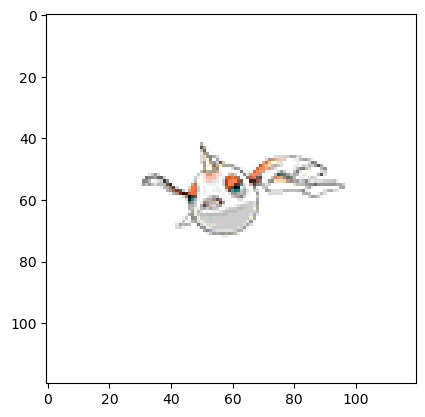

In [27]:
plt.imshow(pokemon_to_arrays['goldeen'])
plt.show()

In [28]:
# img = Image.open('/kaggle/input/pokemon-images-and-types/images/images/throh.png')

# # Convert the image to a NumPy array with RGB data
# rgb_array = np.array(img.convert('RGB'))
# print(rgb_array.shape)

In [29]:
image_shapes = []
for i in pokemon_to_arrays:
    image_shapes.append(pokemon_to_arrays[i].shape)

In [30]:
# find possible pokemon types 
possible_types = list(set(data_labels['Type1'].unique().tolist() + data_labels['Type2'].unique().tolist()))
num_possible_types = len(possible_types)

In [31]:
# convert types into tokens 
data_labels_tokenized = data_labels_name_sorted.copy()
for col in data_labels_tokenized.iloc[:, 1:3]:
    # Replace the values in the column with their index in the list of possible values
    data_labels_tokenized[col] = data_labels_tokenized[col].apply(lambda x: possible_types.index(x))

In [32]:
pokemon_names_in_order = data_labels_tokenized['Name'].to_numpy()
data_labels_tokenized_type1 = data_labels_tokenized['Type1'].to_numpy()
data_labels_tokenized_type2 = data_labels_tokenized['Type2'].to_numpy()


In [33]:
pokemon_images_in_order = []
for name in pokemon_names_in_order:
    pokemon_images_in_order.append(pokemon_to_arrays[name])
pokemon_images_in_order = np.array(pokemon_images_in_order)

In [34]:
# return split data -> training and testing sets
def split_data(all_data, split_ratio):
    all_data_size = len(all_data)
    train_data_size = int(all_data_size * split_ratio)
    train_data = all_data[0:train_data_size]
    test_data = all_data[train_data_size:all_data_size]
    
    return train_data, test_data

# split type1 and type2 into training and testing labels
type1_train_labels, type1_test_labels = split_data(data_labels_tokenized_type1, .8)
type2_train_labels, type2_test_labels = split_data(data_labels_tokenized_type2, .8)

# split data into training and testing data
training_data, testing_data = split_data(pokemon_images_in_order, .8)

# cast all numpy arrays to float
type1_train_labels = type1_train_labels.astype('float32') 
type1_test_labels = type1_test_labels.astype('float32') 
type2_train_labels = type2_train_labels.astype('float32') 
type2_test_labels = type2_test_labels.astype('float32')
training_data = training_data.astype('float32') / 255.
testing_data = testing_data.astype('float32') / 255.

In [35]:
np.amax(training_data)

1.0

In [36]:
print(type(type1_train_labels), type(type1_test_labels), type(type2_train_labels),type(type2_test_labels))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [37]:
# GRADED FUNCTION: train_val_generators
def train_val_generators(training_images, training_labels, validation_images, validation_labels):
    train_datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=.3,
    zoom_range=.01,
    fill_mode='nearest'
      )


    # Pass in the appropriate arguments to the flow method
    train_generator = train_datagen.flow(x=training_images,
                                       y=training_labels,
                                       batch_size=32) 


    # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
    # Remember that validation data should not be augmented
    validation_datagen = ImageDataGenerator()

    # Pass in the appropriate arguments to the flow method
    validation_generator = validation_datagen.flow(x=validation_images,
                                                 y=validation_labels,
                                                 batch_size=32) 

    ### END CODE HERE

    return train_generator, validation_generator

training_type1_gen, testing_type1_gen = train_val_generators(training_data, type1_train_labels, 
                                                             testing_data, type1_test_labels)

training_type2_gen, testing_type2_gen = train_val_generators(training_data, type2_train_labels, 
                                                             testing_data, type2_test_labels)

In [38]:
x_batch, y_batch = next(training_type1_gen)
y_batch.shape

(32,)

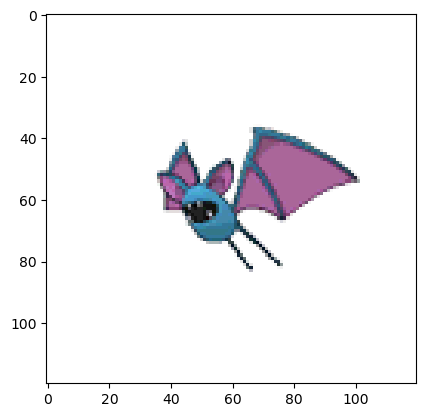

In [39]:
plt.imshow(pokemon_to_arrays['zubat'])
plt.show()

In [40]:
def create_model(num_classes):

    ### START CODE HERE       
    ks = tf.keras
    model = ks.models.Sequential()
    model.add(ks.layers.Dense(4, input_shape=(120, 120, 4)))

    model.add(ks.layers.Conv2D(64, (7, 7), activation='relu'))
    model.add(ks.layers.MaxPooling2D(2, 2))

    model.add(ks.layers.Conv2D(128, (7, 7), activation='relu'))
    model.add(ks.layers.MaxPooling2D(2, 2))



    model.add(ks.layers.Conv2D(256, (7, 7), activation='relu'))
    model.add(ks.layers.MaxPooling2D(2, 2))


    model.add(ks.layers.Conv2D(512, (7, 7), activation='relu'))
    model.add(ks.layers.MaxPooling2D(2, 2))
    model.add(ks.layers.Dropout(0.2))

    model.compile(optimizer = 'adam',
                loss = 'sparse_categorical_crossentropy',
                metrics=['acc'])

    ### END CODE HERE       

    return model


model_type1 = create_model(num_possible_types)

In [41]:
# Train model 
history = model_type1.fit(training_type1_gen,
                   epochs=20,
                   validation_data=testing_type1_gen)

Epoch 1/20
21/21 [==============================] - 85s 4s/step - loss: 12.4214 - acc: 0.1127 - val_loss: 12.6418 - val_acc: 0.1374
Epoch 2/20
21/21 [==============================] - 84s 4s/step - loss: 12.7768 - acc: 0.1298 - val_loss: 12.6400 - val_acc: 0.1374
Epoch 3/20
21/21 [==============================] - 83s 4s/step - loss: 12.7178 - acc: 0.1300 - val_loss: 12.6400 - val_acc: 0.1374
Epoch 4/20
21/21 [==============================] - 83s 4s/step - loss: 12.9307 - acc: 0.1295 - val_loss: 12.6400 - val_acc: 0.1374
Epoch 5/20
21/21 [==============================] - 84s 4s/step - loss: 13.0038 - acc: 0.1298 - val_loss: 12.6400 - val_acc: 0.1315
Epoch 6/20
21/21 [==============================] - 84s 4s/step - loss: 13.0778 - acc: 0.1271 - val_loss: 12.6400 - val_acc: 0.1374
Epoch 7/20
21/21 [==============================] - 83s 4s/step - loss: 12.9652 - acc: 0.1280 - val_loss: 12.6400 - val_acc: 0.1374
Epoch 8/20
21/21 [==============================] - 83s 4s/step - loss: 12.7